# alignment timing

This is a bakeoff between BioPython.Align and edlib's python distro.

## Setup

### Import libraries

In [52]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
from itertools import product
import edlib
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import *
from src.classes import *



### Read in data

In [69]:
fastq = 'tests/data/ONT_test_0001percent.fq.gz'
demux = 'raw_data/ddRAD_ONT_demux.tsv'
fuzzy_aln_percent_array = np.arange(.5,1.1,.1)
exact_aln_percent = 1
buffer = 9

SimpleSeqRecord_lst = parse_seqfile(fastq) # uses FastqGeneralIterator to read big FAs cheaply
### init aligner to avoid having to recreate it every time we call DemuxAlignment
aligner = init_aligner()
# Initialize DataFrame to store timings: rows = replicates, columns = fuzziness values
n_replicates = 1000

# Recreate sample_id_dict for each fuzziness value since it depends on fuzzy_aln_percent
sample_id_dict = make_sample_id_dict(demux, fuzzy_aln_percent, exact_aln_percent, buffer)
input_lst = list(product(SimpleSeqRecord_lst, [sample_id_dict], [aligner]))


### Define plotting functions

In [68]:
def plot_tiled_trendlines(df, title="Individual alignment time trendlines"):
    """
    Create a tiled plot with one subplot per fuzziness category.
    Shows trendlines with standard error bands and unique colors.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for each fuzziness value
    title : str, optional
        Overall title for the plot (default: "Individual alignment time trendlines")
    """
    n_fuzziness = len(df.columns)
    n_cols_grid = 3  # Number of columns in the grid
    n_rows_grid = (n_fuzziness + n_cols_grid - 1) // n_cols_grid  # Calculate rows needed
    
    # Create a color palette for unique colors
    colors = sns.color_palette("husl", n_fuzziness)
    
    fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(15, 5 * n_rows_grid))
    # Flatten axes array for easier indexing (handles both 1D and 2D cases)
    axes = np.array(axes).flatten()
    
    # Window size for rolling mean and standard error calculation
    window_size = max(10, len(df) // 20)  # Adaptive window size
    
    # First pass: calculate all rolling means and SEs to determine global y-axis limits
    all_rolling_means = []
    all_rolling_ses = []
    all_data_dict = {}
    
    for idx, col in enumerate(df.columns):
        data = df[col].values
        rolling_mean = pd.Series(data).rolling(window=window_size, center=True).mean()
        rolling_std = pd.Series(data).rolling(window=window_size, center=True).std()
        rolling_se = rolling_std / np.sqrt(window_size)
        
        all_rolling_means.append(rolling_mean)
        all_rolling_ses.append(rolling_se)
        all_data_dict[col] = {
            'data': data,
            'rolling_mean': rolling_mean,
            'rolling_se': rolling_se
        }
    
    # Calculate global y-axis limits (including error bands)
    global_min = min([(rm - rs).min() for rm, rs in zip(all_rolling_means, all_rolling_ses) if not (rm - rs).isna().all()])
    global_max = max([(rm + rs).max() for rm, rs in zip(all_rolling_means, all_rolling_ses) if not (rm + rs).isna().all()])
    
    # Add a small margin (5%) for better visualization
    y_margin = (global_max - global_min) * 0.05
    y_min = max(0, global_min - y_margin)  # Don't go below 0 for time
    y_max = global_max + y_margin
    
    # Second pass: plot all subplots with shared y-axis scale
    for idx, col in enumerate(df.columns):
        ax = axes[idx]
        fuzziness_value = col.replace('fuzziness_', '')
        data = all_data_dict[col]['data']
        rolling_mean = all_data_dict[col]['rolling_mean']
        rolling_se = all_data_dict[col]['rolling_se']
        x = np.arange(len(data))
        
        # Plot trendline
        ax.plot(x, rolling_mean, color=colors[idx], linewidth=2, label='Trendline')
        
        # Fill area for standard error bands
        ax.fill_between(x, 
                        rolling_mean - rolling_se, 
                        rolling_mean + rolling_se, 
                        color=colors[idx], 
                        alpha=0.3, 
                        label='±1 SE')
        
        # Set shared y-axis limits
        ax.set_ylim(y_min, y_max)
        
        ax.set_title(f'Fuzziness = {fuzziness_value}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Replicate Index', fontsize=10)
        ax.set_ylabel('Alignment Time (seconds)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    # Hide unused subplots if any
    for idx in range(n_fuzziness, len(axes)):
        axes[idx].set_visible(False)
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def plot_superimposed_trendlines(df, title="Superimposed alignment time trendlines"):
    """
    Create a single plot with all fuzziness trendlines superimposed.
    Shows trendlines with standard error bands and unique colors.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns for each fuzziness value
    title : str, optional
        Title for the plot (default: "Superimposed alignment time trendlines")
    """
    n_fuzziness = len(df.columns)
    colors = sns.color_palette("husl", n_fuzziness)
    
    # Window size for rolling mean and standard error calculation
    window_size = max(10, len(df) // 20)
    
    # Calculate rolling means and SEs for all columns
    all_data_dict = {}
    for idx, col in enumerate(df.columns):
        data = df[col].values
        rolling_mean = pd.Series(data).rolling(window=window_size, center=True).mean()
        rolling_std = pd.Series(data).rolling(window=window_size, center=True).std()
        rolling_se = rolling_std / np.sqrt(window_size)
        
        all_data_dict[col] = {
            'rolling_mean': rolling_mean,
            'rolling_se': rolling_se
        }
    
    # Create single plot with all trendlines superimposed
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(df))
    
    # Plot all trendlines and error bands
    for idx, col in enumerate(df.columns):
        fuzziness_value = col.replace('fuzziness_', '')
        rolling_mean = all_data_dict[col]['rolling_mean']
        rolling_se = all_data_dict[col]['rolling_se']
        
        # Plot trendline
        ax.plot(x, rolling_mean, color=colors[idx], linewidth=2, 
                label=f'Fuzziness = {fuzziness_value}')
        
        # Fill area for standard error bands (with lower alpha for better visibility)
        ax.fill_between(x, 
                        rolling_mean - rolling_se, 
                        rolling_mean + rolling_se, 
                        color=colors[idx], 
                        alpha=0.15)  # Lower alpha since multiple bands overlap
    
    ax.set_xlabel('Replicate Index', fontsize=12)
    ax.set_ylabel('Alignment Time (seconds)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()


## BioPython

### Generate timing data

In [ ]:
def align_target(seq: Seq, subseq: Seq, aligner: Align.PairwiseAligner, aln_percent: float = 1):
    '''
    Helper function for `check_seq_for_full_index` and others.
    Takes a Bio.Record object and a Bio.Seq object, and aligns` them.
    Returns a tuple of the start and end indices of 'subseq' to 'seq'.
    Returns a list of two indices which can be formatted to a Boundary object.
    '''
    aligner.target_end_gap_score = aligner.query_end_gap_score = 0.0
    min_aln_score=len(subseq)*aln_percent

    aln=aligner.align(seq, subseq)

    if (aln.score < min_aln_score):
        return([np.nan, np.nan])
    else:
        aln_boundaries=(aln[0].aligned[0].flatten())
        return([min(aln_boundaries), max(aln_boundaries)])

In [95]:
timing_data = {f'fuzziness_{fuzzy:.1f}': [] for fuzzy in fuzzy_aln_percent_array}

for fuzzy_aln_percent in fuzzy_aln_percent_array:    
    for replicate_idx, i in enumerate(input_lst[0:n_replicates]):
        SimpleSeqRecord = i[0]
        sample_id_dict = i[1]
        aligner = i[2]
        
        # Collect timing for the first DCA creation in this replicate
        timing = None
        for sample_id, sample_id_info in sample_id_dict.items():
            DC_lst = sample_id_info[0]
            for DC in DC_lst:
                start = time.process_time()

                ### This is the only section that differs
                aln_idx_full=aligner.align(DC.index_full.seq, SimpleSeqRecord.seq)
                aln_barcode_full=aligner.align(DC.barcode_full.seq, SimpleSeqRecord.seq)

                end = time.process_time()
                timing = end - start
                break  # Only time the first DCA per replicate
            if timing is not None:
                break
        
        # Store timing for this replicate at this fuzziness level
        timing_data[f'fuzziness_{fuzzy_aln_percent:.1f}'].append(timing)

# Create DataFrame with replicates as rows and fuzziness values as columns
aln_times_BioPython = pd.DataFrame(timing_data).iloc[0:,0:6]

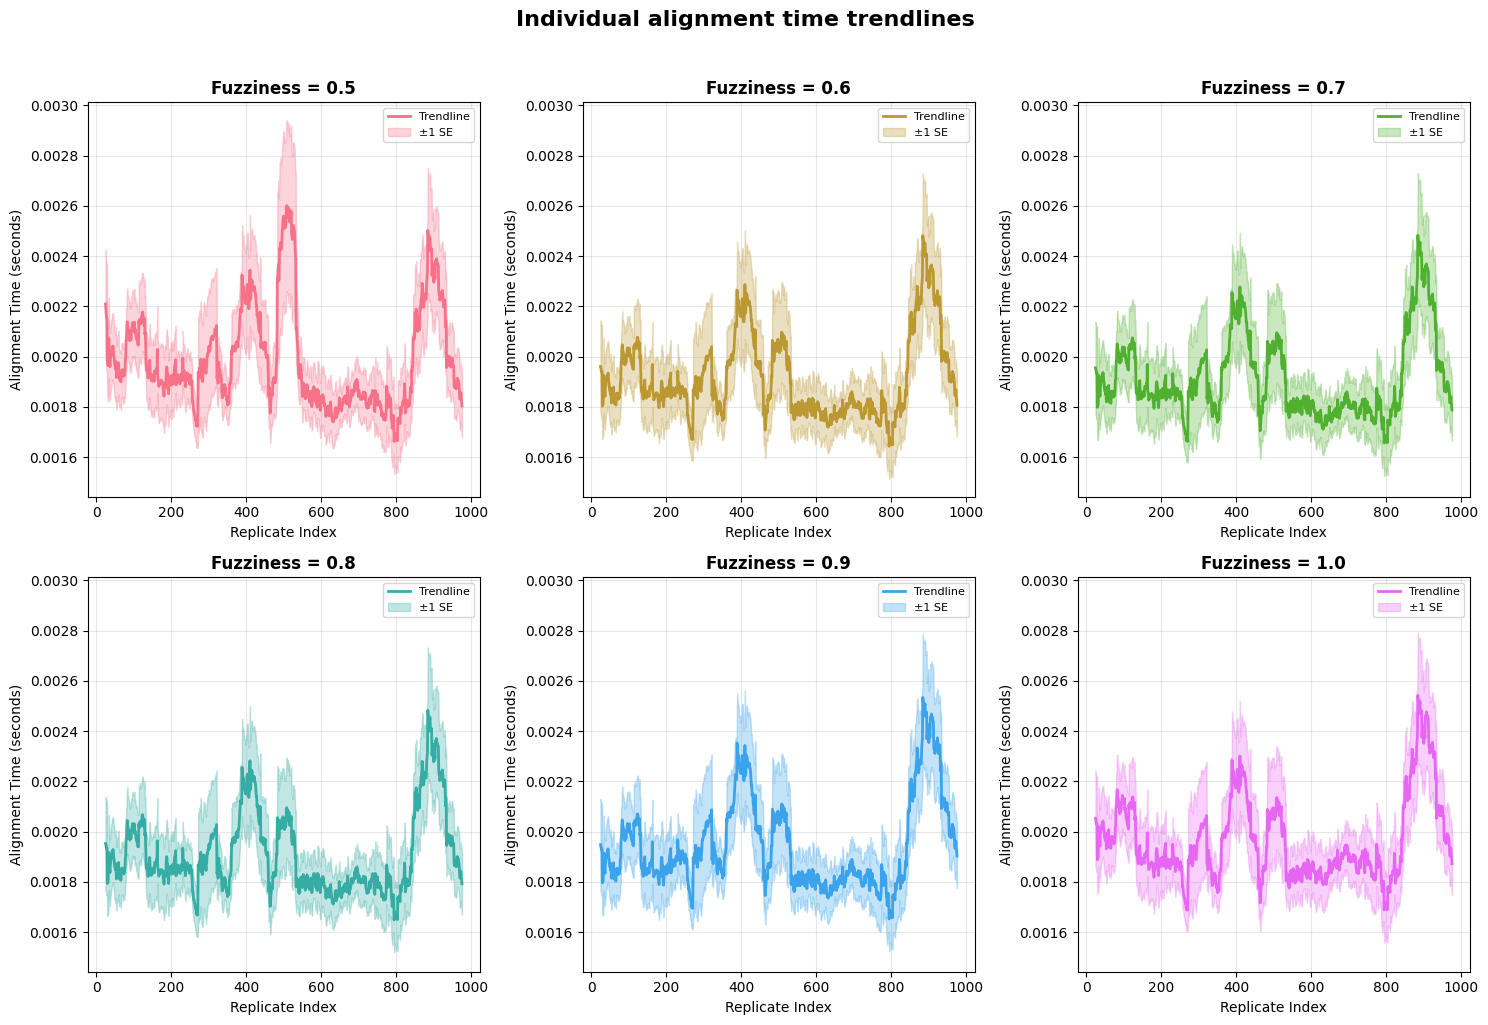

In [96]:
# Generate tiled plot using the function
plot_tiled_trendlines(aln_times_BioPython)

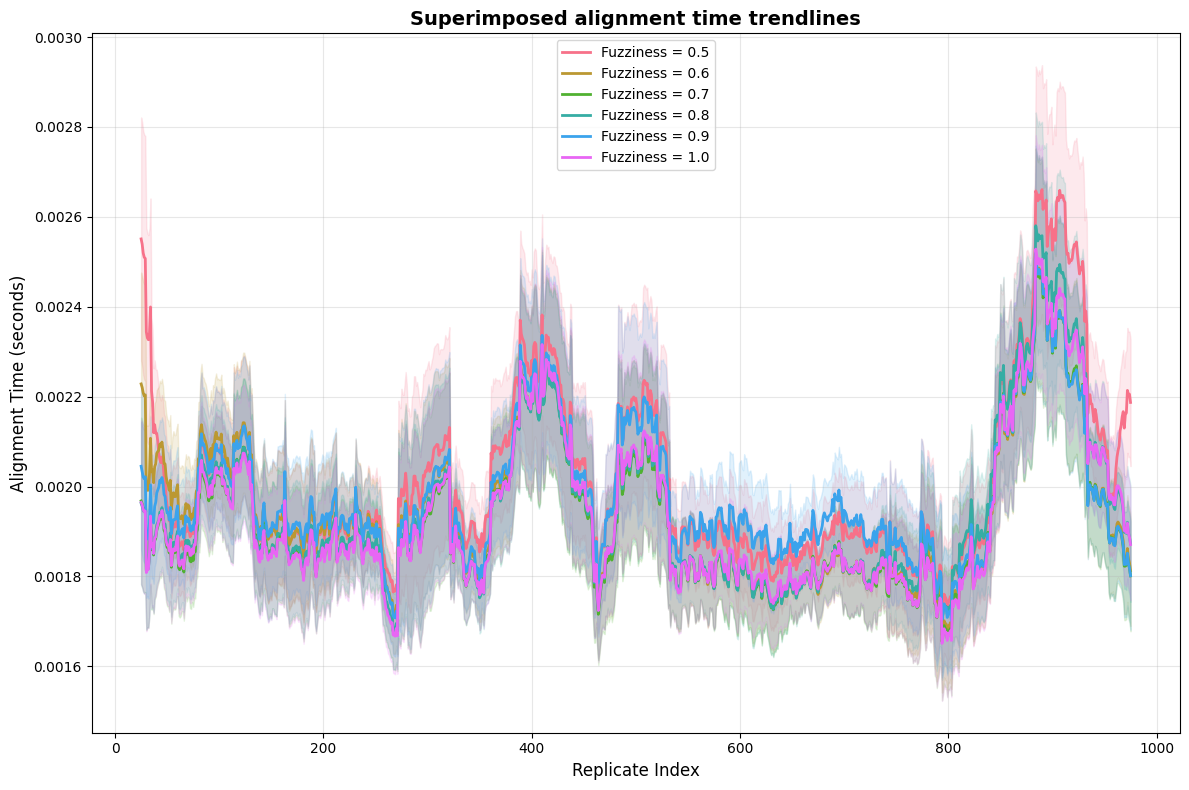

In [ ]:
# Generate superimposed plot using the function
plot_superimposed_trendlines(aln_times_BioPython)

## Edlib

[Edlib](https://github.com/Martinsos/edlib?tab=readme-ov-file#usage-and-examples) is supposed to be a faster alignment program.
We're using the python distribution found [here](https://pypi.org/project/edlib/).

### Generate timing data

In [ ]:
timing_data = {f'fuzziness_{fuzzy:.1f}': [] for fuzzy in fuzzy_aln_percent_array}

for fuzzy_aln_percent in fuzzy_aln_percent_array:    
    for replicate_idx, i in enumerate(input_lst[0:n_replicates]):
        SimpleSeqRecord = i[0]
        sample_id_dict = i[1]
        aligner = i[2]
        
        # Collect timing for the first DCA creation in this replicate
        timing = None
        for sample_id, sample_id_info in sample_id_dict.items():
            DC_lst = sample_id_info[0]
            for DC in DC_lst:
                start = time.process_time()

                ### this is the only section that differs
                aln_idx_full=edlib.align(query=DC.index_full.seq, target=SimpleSeqRecord.seq, mode='HW', task='locations')
                aln_barcode_full=edlib.align(query=DC.barcode_full.seq, target=SimpleSeqRecord.seq, mode='HW', task='locations')

                end = time.process_time()
                timing = end - start
                break  # Only time the first DCA per replicate
            if timing is not None:
                break
        
        # Store timing for this replicate at this fuzziness level
        timing_data[f'fuzziness_{fuzzy_aln_percent:.1f}'].append(timing)

# Create DataFrame with replicates as rows and fuzziness values as columns
aln_times_edlib = pd.DataFrame(timing_data).iloc[0:,0:6]

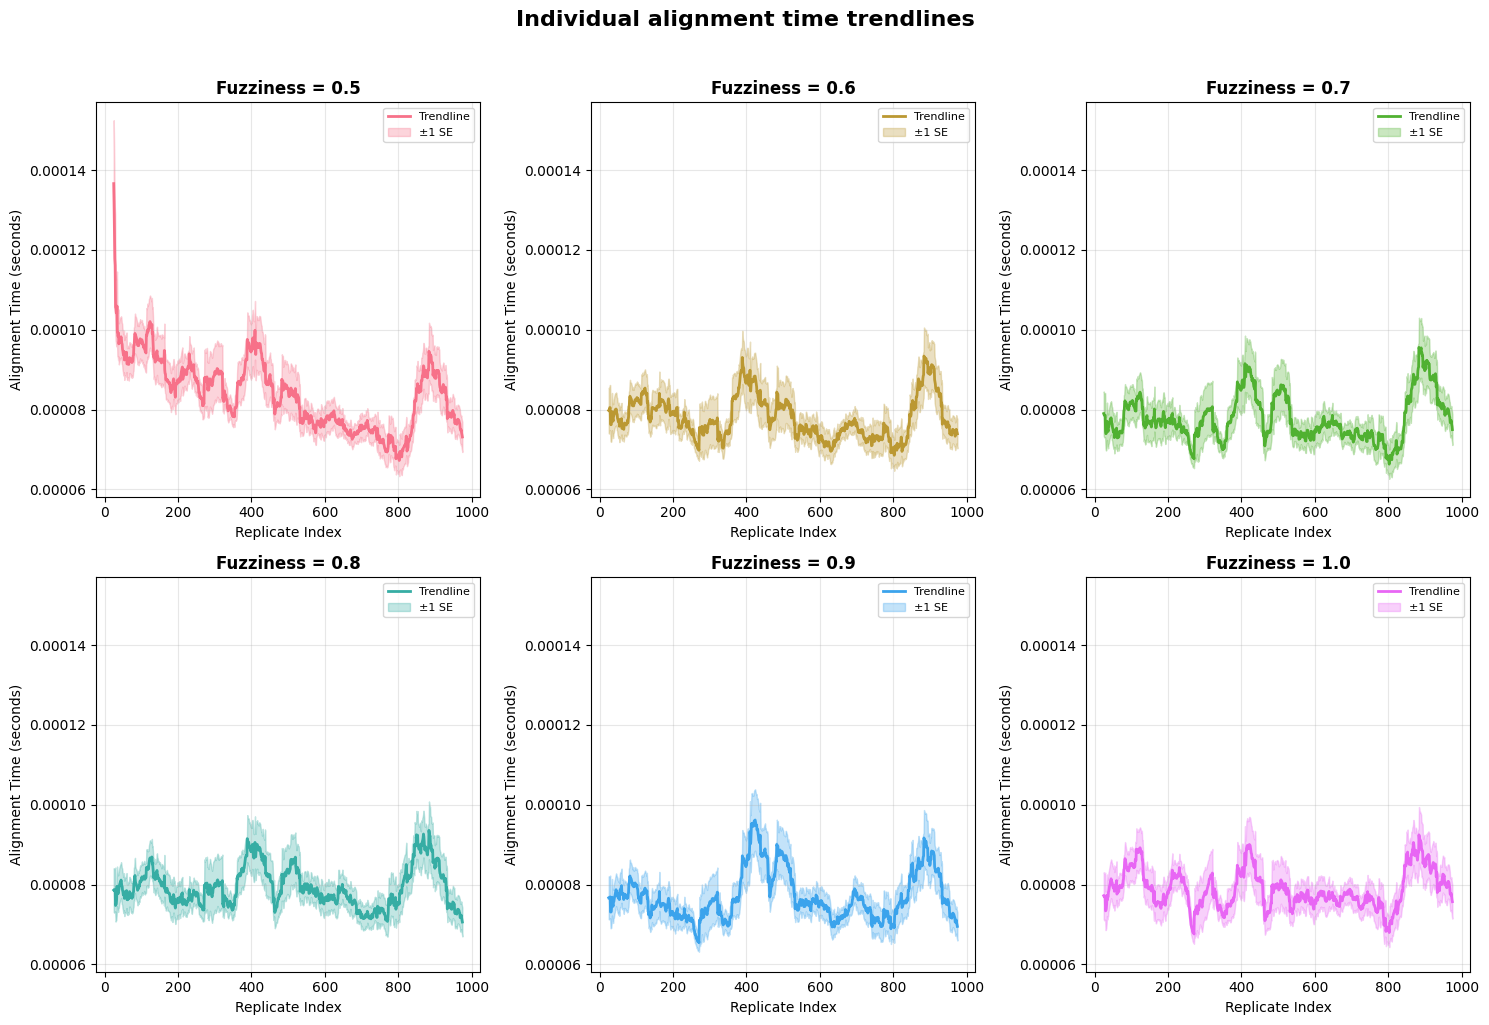

In [99]:
# Generate tiled plot using the function
plot_tiled_trendlines(aln_times_edlib)

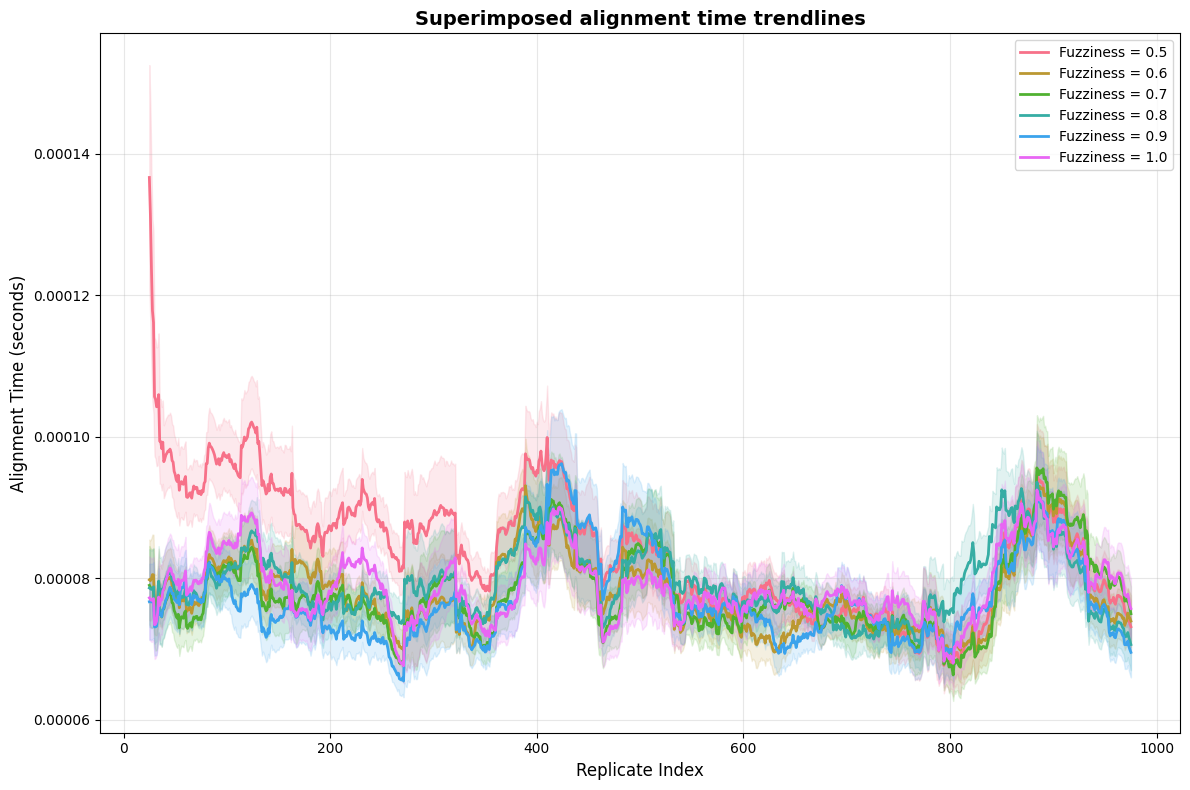

In [100]:
# Generate superimposed plot using the function
plot_superimposed_trendlines(aln_times_edlib)